In [1]:
# get a folder full of images whre the image-classifiers are wrong
# prepare VIT models
# compute alignment scores
# get spearman correlation 
# plot the correlation matrix

In [1]:
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from metrics import AlignmentMetrics
from tqdm import tqdm
import gc  # Garbage collector for memory management
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import seaborn as sns

In [2]:
# -------------------- Initialization --------------------

EXPERIMENT_DIR = "places365/experiment_samples"
NOISE_STEPS_DIR = "noisy_images_steps"
os.makedirs(NOISE_STEPS_DIR, exist_ok=True)

FEATURES_DIR = "model_features"
os.makedirs(FEATURES_DIR, exist_ok=True)

# Load images from the experiment directory
image_files = os.listdir(EXPERIMENT_DIR)
image_files = sorted(image_files)  # Use all selected images, no shuffling or limiting

In [3]:
model_list = [
    "vit_tiny_patch16_224.augreg_in21k",
    "vit_small_patch16_224.augreg_in21k",
    "vit_base_patch16_224.augreg_in21k",
    "vit_large_patch16_224.augreg_in21k",
    "vit_base_patch16_224.mae",
    "vit_large_patch16_224.mae",
    "vit_huge_patch14_224.mae",
    "vit_small_patch14_dinov2.lvd142m",
    "vit_base_patch14_dinov2.lvd142m",
    "vit_large_patch14_dinov2.lvd142m",
    "vit_giant_patch14_dinov2.lvd142m",
    "vit_base_patch16_clip_224.laion2b",
    "vit_large_patch14_clip_224.laion2b",
    "vit_huge_patch14_clip_224.laion2b",
    "vit_base_patch16_clip_224.laion2b_ft_in12k",
    "vit_large_patch14_clip_224.laion2b_ft_in12k",
    "vit_huge_patch14_clip_224.laion2b_ft_in12k",
]


In [4]:
# -------------------- Image Loading --------------------

def load_image_as_array(image_path):
    """Load an image, convert to RGB, and return as a NumPy array normalized to [0, 1]."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load all images as NumPy arrays
loaded_images = [load_image_as_array(os.path.join(EXPERIMENT_DIR, img_file)) for img_file in image_files]
loaded_images = [img for img in loaded_images if img is not None]

# --------

In [1]:
# ------------ Noise Addition Function --------------------

# def save_noisy_images_step(images, step, total_steps):
#     """Blend images with random noise and save them in a folder named after the noise step."""
#     alpha = step / total_steps  # Blending factor, increases linearly
#     step_dir = os.path.join(NOISE_STEPS_DIR, f"step_{step:03d}")
#     os.makedirs(step_dir, exist_ok=True)
    
#     for idx, img in enumerate(images):
#         random_noise = np.random.rand(*img.shape)  # Random noise image
#         noisy_image = (1 - alpha) * img + alpha * random_noise
#         noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values remain in [0, 1]
#         noisy_image_pil = Image.fromarray((noisy_image * 255).astype('uint8'))
#         noisy_image_pil.save(os.path.join(step_dir, f"image_{idx:04d}.png"))

# # Parallel noise addition and saving
# total_steps = 100
# with ThreadPoolExecutor() as executor:
#     futures = [executor.submit(save_noisy_images_step, loaded_images, step, total_steps) for step in range(total_steps)]
#     for future in tqdm(as_completed(futures), total=total_steps, desc="Adding noise to images"):
#         future.result()  # Will raise any exceptions caught during the execution

In [20]:
############################### alignment calculation ############################3

In [21]:


# -------------------- Setup Logging --------------------

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler("feature_extraction.log"),
        logging.StreamHandler()
    ]
)

# -------------------- Helper Functions --------------------

def get_dynamic_settings(model_name, input_size, gpu_memory_gb=24):
    """
    Adjust batch size based on model size and input size to fit within GPU memory constraints.
    """
    # Define keywords to categorize models
    large_models = ["vit_large", "vit_huge", "vit_giant", "dinov2", "clip"]
    medium_models = ["vit_base"]
    small_models = ["vit_small", "vit_tiny"]

    # Default batch size
    batch_size = 32

    # Adjust batch size based on model size
    if any(keyword in model_name for keyword in large_models):
        batch_size = 8  # Further reduced for very large models
    elif any(keyword in model_name for keyword in medium_models):
        batch_size = 16
    elif any(keyword in model_name for keyword in small_models):
        batch_size = 32
    else:
        batch_size = 16  # Fallback batch size

    # Further adjust based on input size if needed
    if max(input_size) > 224:
        batch_size = max(4, batch_size // 2)  # Example adjustment for larger inputs

    return batch_size

def extract_features(model, images, batch_size=32):
    """
    Extract CLS token features from a model for given images using mixed precision.
    """
    features = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.cuda.amp.autocast():
        with torch.no_grad():
            for i in range(0, len(images), batch_size):
                try:
                    batch = torch.stack(images[i:i + batch_size]).to(device)
                except Exception as e:
                    logging.error(f"Error stacking batch {i} to {i + batch_size}: {e}")
                    continue

                try:
                    outputs = model.forward_features(batch)
                    cls_tokens = F.normalize(outputs[:, 0, :], dim=-1)
                    features.append(cls_tokens.cpu())  # Move to CPU to save GPU memory
                except Exception as e:
                    logging.error(f"Error extracting features for batch {i} to {i + batch_size}: {e}")
                    continue

    if features:
        features = torch.cat(features, dim=0)
    else:
        features = torch.tensor([])  # Return empty tensor if no features extracted

    return features

def load_images_from_step(step_dir, target_size=(224, 224)):
    """
    Load all images from a given noise step directory and resize them to the target size.
    """
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    try:
        image_files = sorted([f for f in os.listdir(step_dir) if f.lower().endswith(supported_formats)])
    except Exception as e:
        logging.error(f"Error listing files in directory {step_dir}: {e}")
        return []

    images = []
    for img_file in image_files:
        img_path = os.path.join(step_dir, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(target_size, Image.BILINEAR)  # Resize to target size
                img_tensor = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor
                images.append(img_tensor)
        except Exception as e:
            logging.warning(f"Error loading image {img_path}: {e}")
    return images

def extract_features_for_step(model, step_dir, step, batch_size=32):
    """
    Extract features for a given model and noise step.
    """
    images = load_images_from_step(step_dir)
    if not images:
        raise ValueError(f"No images found in {step_dir}")

    features = extract_features(model, images, batch_size)
    del images  # Free up memory used by images
    torch.cuda.empty_cache()  # Clear any remaining GPU cache
    gc.collect()  # Trigger garbage collection
    return step, features

def process_model(model_name, steps_to_process, NOISE_STEPS_DIR, gpu_memory_gb=24, model_input_sizes=None):
    """
    Process feature extraction for a model across specified steps.
    """
    logging.info(f"Processing model: {model_name}")
    noise_features = {}
    feature_save_path = f"{model_name}_features.pt"

    # Check if features for this model are already saved
    if os.path.exists(feature_save_path):
        logging.info(f"Loading saved features for {model_name} from {feature_save_path}...")
        try:
            noise_features = torch.load(feature_save_path)
            logging.info(f"Loaded features for {model_name} successfully.")
            return noise_features
        except Exception as e:
            logging.error(f"Error loading saved features for {model_name}: {e}")
            # Proceed to re-process the model
            noise_features = {}

    try:
        # Initialize the model
        logging.info(f"Initializing model {model_name}...")
        model = timm.create_model(model_name, pretrained=True)
        logging.info(f"Model {model_name} initialized successfully.")

        # Get the model's input size
        input_size = model.default_cfg.get('input_size', (3, 224, 224))
        if model_input_sizes and model_name in model_input_sizes:
            height, width = model_input_sizes[model_name]
            logging.info(f"Overriding input size for {model_name} to ({height}, {width}) as per predefined mapping.")
        elif isinstance(input_size, (list, tuple)) and len(input_size) == 3:
            _, height, width = input_size
        else:
            height, width = 224, 224  # Default fallback
        logging.info(f"Model {model_name} expects input size: ({height}, {width})")

        # Adjust batch size based on model size and input size
        batch_size = get_dynamic_settings(model_name, height)
        logging.info(f"Using batch size: {batch_size} for model {model_name}")

        for step in steps_to_process:
            step_dir = os.path.join(NOISE_STEPS_DIR, f"step_{step:03d}")
            if not os.path.isdir(step_dir):
                logging.warning(f"Directory {step_dir} does not exist. Skipping step {step}.")
                continue
            try:
                step_num, features = extract_features_for_step(model, step_dir, step, batch_size)
                noise_features[step_num] = features
                torch.save(noise_features, feature_save_path)  # Save incrementally
                logging.info(f"Saved features for model {model_name}, step {step_num}.")
            except Exception as e:
                logging.error(f"Error processing step {step} for model {model_name}: {e}")

    except Exception as e:
        logging.error(f"Error initializing model {model_name}: {e}")
    finally:
        # Ensure model is deleted and memory is freed
        if 'model' in locals():
            del model
            torch.cuda.empty_cache()
            gc.collect()
            logging.info(f"Cleared GPU memory after processing model {model_name}.")

    return noise_features

def compute_alignment_scores(model_features_noise, model_list, steps_to_process):
    """
    Calculate alignment scores between all pairs of models at different noise levels.
    """
    alignment_records = []

    # Calculate alignment scores at different noise levels
    for step in steps_to_process:
        for model_a, model_b in itertools.combinations(model_list, 2):
            try:
                features_a = model_features_noise[model_a][step]
                features_b = model_features_noise[model_b][step]
                score = AlignmentMetrics.mutual_knn(features_a, features_b, topk=50)

                alignment_records.append({
                    'Model A': model_a,
                    'Model B': model_b,
                    'Step': step,
                    'Score': score
                })
            except KeyError as ke:
                logging.warning(f"Missing features for step {step}: {ke}")
            except Exception as e:
                logging.error(f"Error calculating alignment score for models {model_a} and {model_b} at step {step}: {e}")

    # Create DataFrame from results
    score_df = pd.DataFrame(alignment_records)
    return score_df

def plot_results(score_df):
    """
    Plot alignment scores as noise increases.
    """
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=score_df, x='Step', y='Score', hue='Model A', style='Model B', markers=True)
    plt.title('Alignment Score (mutual_knn) vs. Noise Level')
    plt.xlabel('Noise Step (0 = original, 100 = random noise)')
    plt.ylabel('Alignment Score')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# -------------------- Main Execution --------------------

Processing models:   0%|                                                                                             | 0/17 [00:00<?, ?it/s]2024-10-24 00:12:37,714 [INFO] Processing model: vit_tiny_patch16_224.augreg_in21k
2024-10-24 00:12:37,714 [INFO] Loading saved features for vit_tiny_patch16_224.augreg_in21k from vit_tiny_patch16_224.augreg_in21k_features.pt...
/tmp/ipykernel_37642/1971613063.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

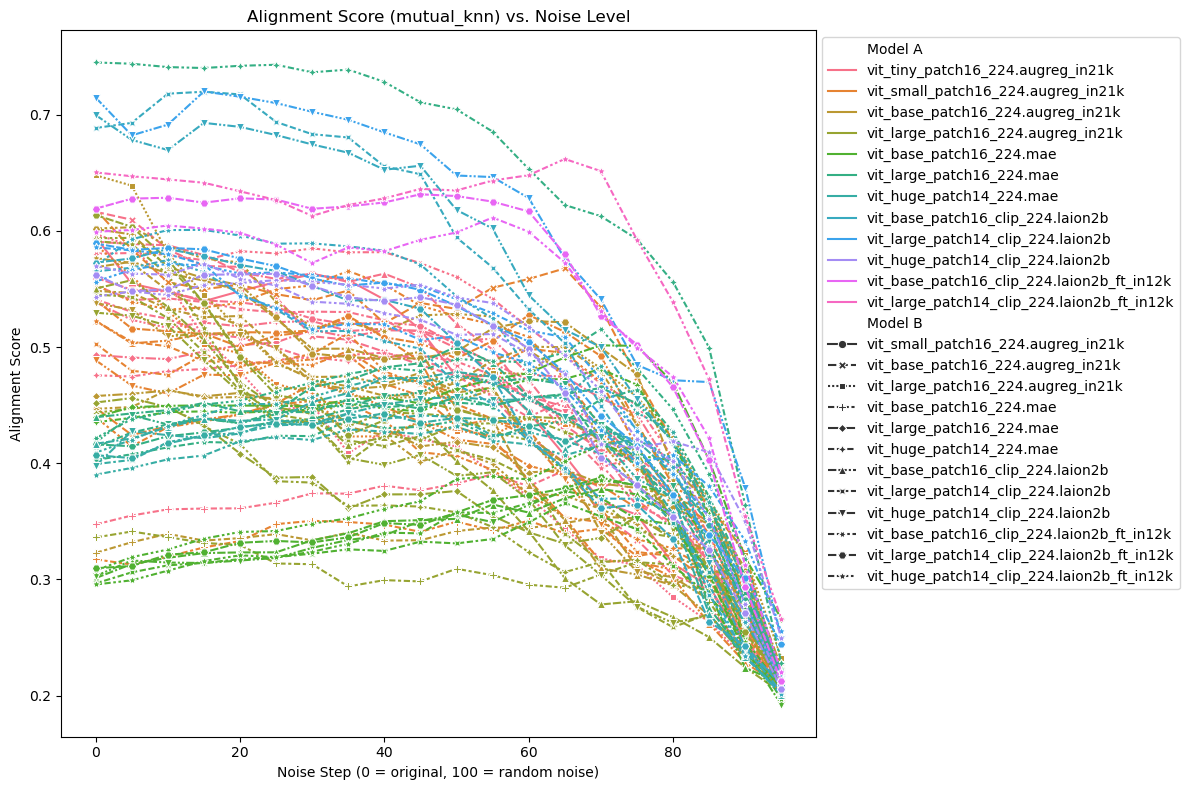

2024-10-24 00:13:08,249 [INFO] Feature extraction and alignment computation completed successfully.
2024-10-24 00:13:08,249 [INFO] Model vit_tiny_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,250 [INFO] Model vit_small_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,251 [INFO] Model vit_base_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,251 [INFO] Model vit_large_patch16_224.augreg_in21k has features for all steps.
2024-10-24 00:13:08,252 [INFO] Model vit_base_patch16_224.mae has features for all steps.
2024-10-24 00:13:08,252 [INFO] Model vit_large_patch16_224.mae has features for all steps.
2024-10-24 00:13:08,252 [INFO] Model vit_huge_patch14_224.mae has features for all steps.
2024-10-24 00:13:08,253 [WARNING] Model vit_small_patch14_dinov2.lvd142m is missing features for steps: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
2024-10-24 00:13:08,253 [WARNING] Model vit_base

In [22]:
gpu_memory_gb = 24  # GPU memory in GB
steps_to_process = range(0, 100, 5)  # Process steps with an interval of 5 (0, 5, 10, ..., 95)

# Define a mapping of model names to their expected input sizes if they deviate from default
model_input_sizes = {
    "vit_small_patch14_dinov2.lvd142m": (518, 518),
    "vit_base_patch14_dinov2.lvd142m": (518, 518),
    "vit_large_patch14_dinov2.lvd142m": (518, 518),
    "vit_giant_patch14_dinov2.lvd142m": (518, 518),
    # Add other models with custom input sizes here if needed
}

# Check available models in timm
available_models = set(timm.list_models(pretrained=True))
missing_models = [model for model in model_list if model not in available_models]
if missing_models:
    logging.warning(f"The following models are not available in timm and will be skipped: {missing_models}")
    # Remove missing models from the list
    model_list = [model for model in model_list if model in available_models]

model_features_noise = {}

# Initialize a single tqdm progress bar for model processing
for model_name in tqdm(model_list, desc="Processing models"):
    features = process_model(
        model_name=model_name,
        steps_to_process=steps_to_process,
        NOISE_STEPS_DIR=NOISE_STEPS_DIR,
        gpu_memory_gb=gpu_memory_gb,
        model_input_sizes=model_input_sizes
    )
    model_features_noise[model_name] = features

# -------------------- Alignment Metric Computation --------------------

score_df = compute_alignment_scores(model_features_noise, model_list, steps_to_process)

# -------------------- Plotting the Results --------------------

plot_results(score_df)
logging.info("Feature extraction and alignment computation completed successfully.")

# -------------------- Verification of All Features --------------------

expected_steps = set(steps_to_process)
for model_name in model_list:
    available_steps = set(model_features_noise.get(model_name, {}).keys())
    missing_steps = expected_steps - available_steps
    if missing_steps:
        logging.warning(f"Model {model_name} is missing features for steps: {sorted(missing_steps)}")
    else:
        logging.info(f"Model {model_name} has features for all steps.")


In [25]:
score_df.to_csv("alignment_scores.csv")

In [38]:
plot_results(score_df)

2024-10-24 00:26:10,604 [INFO] Main alignment plot saved as 'alignment_plot.png'.
2024-10-24 00:26:12,211 [INFO] Legend saved as 'legend.png'.


In [28]:
score_df.head()

,Model A,Model B,Step,Score
0,vit_tiny_patch16_224.augreg_in21k,vit_small_patch16_224.augreg_in21k,0,0.59448
1,vit_tiny_patch16_224.augreg_in21k,vit_base_patch16_224.augreg_in21k,0,0.61640
2,vit_tiny_patch16_224.augreg_in21k,vit_large_patch16_224.augreg_in21k,0,0.59712
3,vit_tiny_patch16_224.augreg_in21k,vit_base_patch16_224.mae,0,0.34736
4,vit_tiny_patch16_224.augreg_in21k,vit_large_patch16_224.mae,0,0.49304


In [7]:
# Total steps for noise addition
total_steps = 100

# Create a dictionary mapping each step to its corresponding noise level (alpha)
noise_levels_dict = {step: step / total_steps for step in range(total_steps + 1)}

# Display the noise levels dictionary
print("\nNoise Levels Dictionary:")
print(noise_levels_dict)


# Load the alignment scores from the CSV file
# Replace 'alignment_scores.csv' with the path to your CSV file
df = pd.read_csv('alignment_scores.csv')


Noise Levels Dictionary:
{0: 0.0, 1: 0.01, 2: 0.02, 3: 0.03, 4: 0.04, 5: 0.05, 6: 0.06, 7: 0.07, 8: 0.08, 9: 0.09, 10: 0.1, 11: 0.11, 12: 0.12, 13: 0.13, 14: 0.14, 15: 0.15, 16: 0.16, 17: 0.17, 18: 0.18, 19: 0.19, 20: 0.2, 21: 0.21, 22: 0.22, 23: 0.23, 24: 0.24, 25: 0.25, 26: 0.26, 27: 0.27, 28: 0.28, 29: 0.29, 30: 0.3, 31: 0.31, 32: 0.32, 33: 0.33, 34: 0.34, 35: 0.35, 36: 0.36, 37: 0.37, 38: 0.38, 39: 0.39, 40: 0.4, 41: 0.41, 42: 0.42, 43: 0.43, 44: 0.44, 45: 0.45, 46: 0.46, 47: 0.47, 48: 0.48, 49: 0.49, 50: 0.5, 51: 0.51, 52: 0.52, 53: 0.53, 54: 0.54, 55: 0.55, 56: 0.56, 57: 0.57, 58: 0.58, 59: 0.59, 60: 0.6, 61: 0.61, 62: 0.62, 63: 0.63, 64: 0.64, 65: 0.65, 66: 0.66, 67: 0.67, 68: 0.68, 69: 0.69, 70: 0.7, 71: 0.71, 72: 0.72, 73: 0.73, 74: 0.74, 75: 0.75, 76: 0.76, 77: 0.77, 78: 0.78, 79: 0.79, 80: 0.8, 81: 0.81, 82: 0.82, 83: 0.83, 84: 0.84, 85: 0.85, 86: 0.86, 87: 0.87, 88: 0.88, 89: 0.89, 90: 0.9, 91: 0.91, 92: 0.92, 93: 0.93, 94: 0.94, 95: 0.95, 96: 0.96, 97: 0.97, 98: 0.98, 99:

Sample of the data:
   Unnamed: 0                            Model A  \
0           0  vit_tiny_patch16_224.augreg_in21k   
1           1  vit_tiny_patch16_224.augreg_in21k   
2           2  vit_tiny_patch16_224.augreg_in21k   
3           3  vit_tiny_patch16_224.augreg_in21k   
4           4  vit_tiny_patch16_224.augreg_in21k   

                              Model B  Step    Score  
0  vit_small_patch16_224.augreg_in21k     0  0.59448  
1   vit_base_patch16_224.augreg_in21k     0  0.61640  
2  vit_large_patch16_224.augreg_in21k     0  0.59712  
3            vit_base_patch16_224.mae     0  0.34736  
4           vit_large_patch16_224.mae     0  0.49304  

Mean alignment scores at each step:
    Step     Score
0      0  0.505711
1      5  0.503208
2     10  0.500117
3     15  0.496359
4     20  0.490928
5     25  0.484844
6     30  0.481440
7     35  0.478751
8     40  0.476744
9     45  0.474392
10    50  0.467807
11    55  0.462256
12    60  0.449019
13    65  0.435757
14    70  0.417

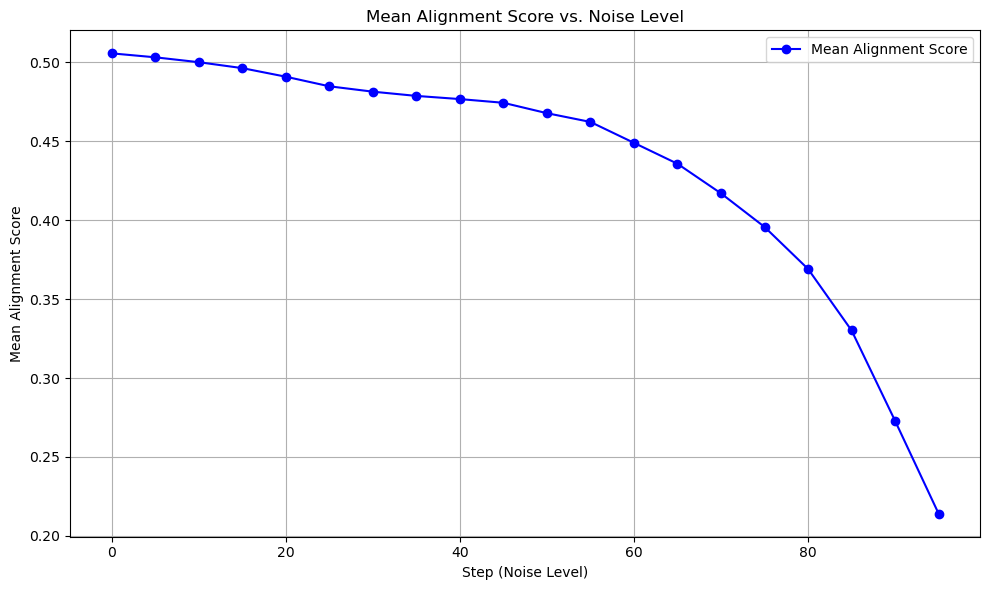

In [4]:
# Display the first few rows to understand the structure
print("Sample of the data:")
print(df.head())

# Calculate the mean score for each step
mean_scores = df.groupby('Step')['Score'].mean().reset_index()

# Display the calculated mean scores
print("\nMean alignment scores at each step:")
print(mean_scores)

# Plot the mean scores over different steps
plt.figure(figsize=(10, 6))
plt.plot(mean_scores['Step'], mean_scores['Score'], marker='o', linestyle='-', color='b', label='Mean Alignment Score')
plt.xlabel('Step (Noise Level)')
plt.ylabel('Mean Alignment Score')
plt.title('Mean Alignment Score vs. Noise Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Mean alignment scores at each signal level:
    Signal Level     Score
0           0.05  0.214077
1           0.10  0.272866
2           0.15  0.330157
3           0.20  0.369113
4           0.25  0.395748
5           0.30  0.417001
6           0.35  0.435757
7           0.40  0.449019
8           0.45  0.462256
9           0.50  0.467807
10          0.55  0.474392
11          0.60  0.476744
12          0.65  0.478751
13          0.70  0.481440
14          0.75  0.484844
15          0.80  0.490928
16          0.85  0.496359
17          0.90  0.500117
18          0.95  0.503208
19          1.00  0.505711


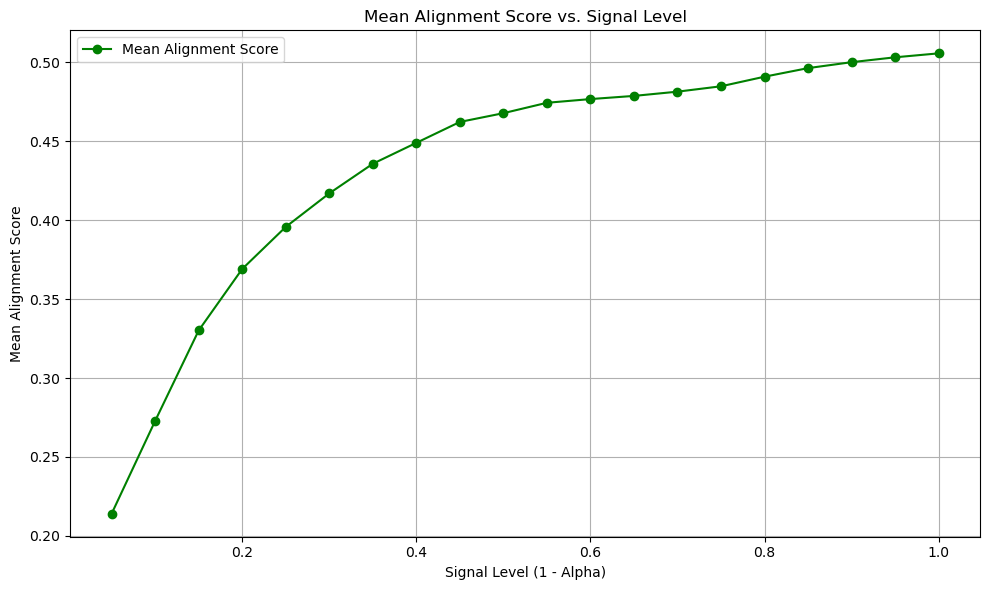

In [9]:
# Assume 'noise_levels_dict' is available and maps step to noise level
# Example: noise_levels_dict = {0: 0.0, 1: 0.01, ..., 100: 1.0}

# Map each step to its corresponding noise level in the DataFrame
df['Noise Level'] = df['Step'].map(noise_levels_dict)

# Calculate the signal level as (1 - Noise Level)
df['Signal Level'] = 1 - df['Noise Level']

# Calculate the mean score for each signal level
mean_scores_signal = df.groupby('Signal Level')['Score'].mean().reset_index()

# Display the calculated mean scores for each signal level
print("\nMean alignment scores at each signal level:")
print(mean_scores_signal)

# Plot the mean scores over different signal levels
plt.figure(figsize=(10, 6))
plt.plot(mean_scores_signal['Signal Level'], mean_scores_signal['Score'], marker='o', linestyle='-', color='g', label='Mean Alignment Score')
plt.xlabel('Signal Level (1 - Alpha)')
plt.ylabel('Mean Alignment Score')
plt.title('Mean Alignment Score vs. Signal Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
##################### divergences ########################

In [5]:
# -------------------- Load Images and Compute Divergences (Parallelized) --------------------

import os
import logging
import gc
from tqdm import tqdm
import pandas as pd
from PIL import Image
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from concurrent.futures import ThreadPoolExecutor, as_completed

# Directory paths
EXPERIMENT_DIR = "places365/experiment_samples"
NOISE_STEPS_DIR = "noisy_images_steps"
divergence_output_file = "divergence_records.csv"

# Function to load images from a specific noise step directory
def load_images_from_step(step):
    """Load all images from a given noise step directory."""
    step_dir = os.path.join(NOISE_STEPS_DIR, f"step_{step:03d}")
    image_files = sorted([f for f in os.listdir(step_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    images = []
    for img_file in image_files:
        img_path = os.path.join(step_dir, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")  # Ensure images are in RGB format
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                images.append(img_array)
        except Exception as e:
            logging.warning(f"Error loading image {img_path}: {e}")
    return images

# Function to compute mean KL divergence and Wasserstein distance between two sets of images
def compute_mean_divergences(images_a, images_b, step_a, step_b):
    """Compute mean KL divergence and Wasserstein distance between two sets of images."""
    kl_divs = []
    wass_dists = []

    # Flatten the images for comparison (convert from 3D to 1D)
    flattened_a = [img.flatten() for img in images_a]
    flattened_b = [img.flatten() for img in images_b]

    for img_a, img_b in zip(flattened_a, flattened_b):
        try:
            # Compute KL Divergence and Wasserstein distance
            kl_div = entropy(img_a + 1e-10, img_b + 1e-10)  # Add small value to avoid log(0)
            wass_dist = wasserstein_distance(img_a, img_b)

            kl_divs.append(kl_div)
            wass_dists.append(wass_dist)
        except Exception as e:
            logging.error(f"Error computing divergence for Step {step_a} vs Step {step_b}: {e}")

    # Calculate mean divergences
    mean_kl_div = np.mean(kl_divs)
    mean_wass_dist = np.mean(wass_dists)

    print(f"Step {step_a} vs Step {step_b}: Mean KL={mean_kl_div:.5f}, Mean WD={mean_wass_dist:.5f}")

    return {
        'Step A': step_a,
        'Step B': step_b,
        'Mean KL Divergence': mean_kl_div,
        'Mean Wasserstein Distance': mean_wass_dist
    }

# -------------------- Divergence Calculation --------------------

# Load images for step_0 only once
print("Loading images for step_0...")
images_step_0 = load_images_from_step(0)

# Define the steps to process (1, 2, ..., 99)
steps_to_process = range(0, 100,5)

# Use a limited number of workers for parallel execution
max_workers = 2

# Create a list to store divergence records
divergence_records = []

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = []

    # Submit divergence calculation tasks for each step with step_0
    for step_b in steps_to_process:
        images_step_b = load_images_from_step(step_b)
        futures.append(executor.submit(compute_mean_divergences, images_step_0, images_step_b, 0, step_b))

    # Process the results as they complete
    for future in tqdm(as_completed(futures), total=len(futures), desc="Calculating divergences"):
        try:
            result = future.result()
            if result:
                divergence_records.append(result)

                # Write results incrementally to avoid data loss
                pd.DataFrame([result]).to_csv(
                    divergence_output_file, 
                    mode='a', 
                    header=not os.path.exists(divergence_output_file), 
                    index=False
                )
                gc.collect()  # Clear memory after saving each result

        except Exception as e:
            logging.error(f"Error processing a divergence result: {e}")

# Free up memory used by images
del images_step_0
gc.collect()

print("Divergence calculation completed and results saved.")

Loading images for step_0...
Step 0 vs Step 25: Mean KL=0.04823, Mean WD=0.05496Step 0 vs Step 30: Mean KL=0.06303, Mean WD=0.06407
Step 0 vs Step 35: Mean KL=0.07918, Mean WD=0.07231


Calculating divergences:   0%|                                                                                       | 0/20 [00:00<?, ?it/s]

Step 0 vs Step 40: Mean KL=0.09663, Mean WD=0.07945


Calculating divergences:   5%|███▉                                                                           | 1/20 [00:06<02:04,  6.58s/it]

Step 0 vs Step 45: Mean KL=0.11542, Mean WD=0.08530Step 0 vs Step 5: Mean KL=0.00426, Mean WD=0.01178
Step 0 vs Step 50: Mean KL=0.13560, Mean WD=0.08973


Calculating divergences:  10%|███████▉                                                                       | 2/20 [00:07<01:02,  3.45s/it]

Step 0 vs Step 0: Mean KL=0.00000, Mean WD=0.00000
Step 0 vs Step 55: Mean KL=0.15746, Mean WD=0.09305
Step 0 vs Step 60: Mean KL=0.18098, Mean WD=0.09558


Calculating divergences:  15%|███████████▊                                                                   | 3/20 [00:21<02:21,  8.34s/it]

Step 0 vs Step 10: Mean KL=0.01238, Mean WD=0.02339


Calculating divergences:  20%|███████████████▊                                                               | 4/20 [00:27<01:53,  7.07s/it]

Step 0 vs Step 65: Mean KL=0.20655, Mean WD=0.09778Step 0 vs Step 70: Mean KL=0.23451, Mean WD=0.09986
Step 0 vs Step 75: Mean KL=0.26531, Mean WD=0.10221
Step 0 vs Step 15: Mean KL=0.02271, Mean WD=0.03451
Step 0 vs Step 80: Mean KL=0.29975, Mean WD=0.10494


Calculating divergences:  25%|███████████████████▊                                                           | 5/20 [00:38<02:06,  8.47s/it]

Step 0 vs Step 20: Mean KL=0.03474, Mean WD=0.04504


Calculating divergences:  30%|███████████████████████▋                                                       | 6/20 [00:46<01:56,  8.29s/it]

Step 0 vs Step 85: Mean KL=0.33920, Mean WD=0.10833Step 0 vs Step 90: Mean KL=0.38550, Mean WD=0.11271
Step 0 vs Step 95: Mean KL=0.44403, Mean WD=0.11806
Step 0 vs Step 25: Mean KL=0.04823, Mean WD=0.05496


Calculating divergences:  35%|███████████████████████████▋                                                   | 7/20 [00:52<01:40,  7.70s/it]

Step 0 vs Step 30: Mean KL=0.06303, Mean WD=0.06407


Calculating divergences:  40%|███████████████████████████████▌                                               | 8/20 [01:03<01:43,  8.65s/it]

Step 0 vs Step 35: Mean KL=0.07918, Mean WD=0.07231


Calculating divergences:  45%|███████████████████████████████████▌                                           | 9/20 [01:06<01:16,  6.99s/it]

Step 0 vs Step 40: Mean KL=0.09663, Mean WD=0.07945


Calculating divergences:  50%|███████████████████████████████████████                                       | 10/20 [01:20<01:30,  9.04s/it]

Step 0 vs Step 45: Mean KL=0.11542, Mean WD=0.08530


Calculating divergences:  55%|██████████████████████████████████████████▉                                   | 11/20 [01:20<00:57,  6.35s/it]

Step 0 vs Step 50: Mean KL=0.13560, Mean WD=0.08973


Calculating divergences:  60%|██████████████████████████████████████████████▊                               | 12/20 [01:34<01:09,  8.63s/it]

Step 0 vs Step 60: Mean KL=0.18098, Mean WD=0.09558


Calculating divergences:  65%|██████████████████████████████████████████████████▋                           | 13/20 [01:37<00:48,  6.91s/it]

Step 0 vs Step 55: Mean KL=0.15746, Mean WD=0.09305


Calculating divergences:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [01:48<00:48,  8.15s/it]

Step 0 vs Step 65: Mean KL=0.20655, Mean WD=0.09778


Calculating divergences:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [01:54<00:37,  7.50s/it]

Step 0 vs Step 70: Mean KL=0.23451, Mean WD=0.09986


Calculating divergences:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [02:02<00:30,  7.64s/it]

Step 0 vs Step 75: Mean KL=0.26531, Mean WD=0.10221


Calculating divergences:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [02:11<00:24,  8.11s/it]

Step 0 vs Step 80: Mean KL=0.29975, Mean WD=0.10494


Calculating divergences:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [02:16<00:14,  7.12s/it]

Step 0 vs Step 85: Mean KL=0.33920, Mean WD=0.10833


Calculating divergences:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [02:28<00:08,  8.71s/it]

Step 0 vs Step 90: Mean KL=0.38550, Mean WD=0.11271


Calculating divergences: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.51s/it]

Step 0 vs Step 95: Mean KL=0.44403, Mean WD=0.11806
Divergence calculation completed and results saved.


In [16]:
import pandas as pd

# Convert divergence_records to a DataFrame
divergence_df = pd.DataFrame(divergence_records)

# Rename columns to be lowercase and without spaces
divergence_df.columns = divergence_df.columns.str.lower().str.replace(' ', '_')

# Save to CSV file
divergence_df.to_csv("divergence_records.csv", index=False)

print("Divergence records saved to 'divergence_records.csv'.")


Divergence records saved to 'divergence_records.csv'.


In [17]:
# -------------------- Plot KL Divergence vs. Alignment Score --------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the divergence records and alignment scores
divergence_df = pd.read_csv("divergence_records.csv")
alignment_df = pd.read_csv("alignment_scores.csv")

In [9]:
divergence_df.head()

NameError: name 'divergence_df' is not defined

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# Load the divergence records and alignment scores
divergence_df = pd.read_csv("divergence_records.csv")
alignment_df = pd.read_csv("alignment_scores.csv")

# Display a few rows to verify the loaded data
print("Divergence Data Sample:")
print(divergence_df.head())

print("\nAlignment Data Sample:")
print(alignment_df.head())

# Calculate the mean alignment score for each step from alignment_df
mean_alignment_scores = alignment_df.groupby('Step')['Score'].mean().reset_index()
mean_alignment_scores.columns = ['Step', 'Mean Alignment Score']

# Rename 'step_b' to 'Step' in divergence_df for consistency
divergence_df = divergence_df.rename(columns={'step_b': 'Step'})

# Merge the alignment scores with KL divergence and Wasserstein distance data
combined_df = pd.merge(mean_alignment_scores, 
                       divergence_df[['Step', 'mean_kl_divergence', 'mean_wasserstein_distance']], 
                       on='Step')

# Display a few rows of the combined data to verify the merge
print("\nCombined Data Sample:")
print(combined_df.head())

# -------------------- Normalized Entropy Calculation --------------------

# Normalized entropy calculation (if required)
def calculate_normalized_entropy(values):
    """
    Calculate the normalized entropy for a set of values.
    Normalized entropy = entropy / log(number of unique values)
    """
    value_counts = pd.Series(values).value_counts(normalize=True)
    return entropy(value_counts) / np.log(len(value_counts))

# Calculate normalized entropy for each step's alignment scores
normalized_entropies = alignment_df.groupby('Step')['Score'].apply(calculate_normalized_entropy).reset_index()
normalized_entropies.columns = ['Step', 'Normalized Entropy']

# Merge the normalized entropy with the combined data
combined_df = pd.merge(combined_df, normalized_entropies, on='Step')

# Display a few rows of the combined data with normalized entropy
print("\nCombined Data with Normalized Entropy:")
print(combined_df.head())

# -------------------- Plotting --------------------

Divergence Data Sample:
   step_a  step_b  mean_kl_divergence  mean_wasserstein_distance
0       0       5            0.004264                   0.011782
1       0       0            0.000000                   0.000000
2       0      10            0.012381                   0.023389
3       0      15            0.022713                   0.034512
4       0      20            0.034742                   0.045043

Alignment Data Sample:
   Unnamed: 0                            Model A  \
0           0  vit_tiny_patch16_224.augreg_in21k   
1           1  vit_tiny_patch16_224.augreg_in21k   
2           2  vit_tiny_patch16_224.augreg_in21k   
3           3  vit_tiny_patch16_224.augreg_in21k   
4           4  vit_tiny_patch16_224.augreg_in21k   

                              Model B  Step    Score  
0  vit_small_patch16_224.augreg_in21k     0  0.59448  
1   vit_base_patch16_224.augreg_in21k     0  0.61640  
2  vit_large_patch16_224.augreg_in21k     0  0.59712  
3            vit_base_patch16

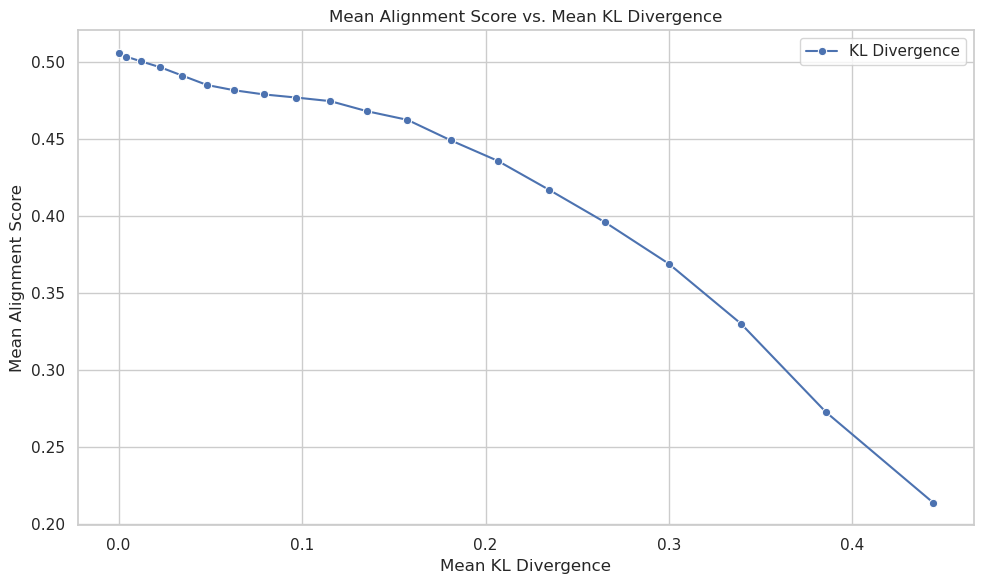

In [26]:
# Set up the plotting style
sns.set(style="whitegrid")

# Create a plot for Mean KL Divergence vs. Mean Alignment Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='mean_kl_divergence', y='Mean Alignment Score', marker='o', color='b', label='KL Divergence')
plt.title('Mean Alignment Score vs. Mean KL Divergence')
plt.xlabel('Mean KL Divergence')
plt.ylabel('Mean Alignment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Sample of the data:
   Unnamed: 0                            Model A  \
0           0  vit_tiny_patch16_224.augreg_in21k   
1           1  vit_tiny_patch16_224.augreg_in21k   
2           2  vit_tiny_patch16_224.augreg_in21k   
3           3  vit_tiny_patch16_224.augreg_in21k   
4           4  vit_tiny_patch16_224.augreg_in21k   

                              Model B  Step    Score  
0  vit_small_patch16_224.augreg_in21k     0  0.59448  
1   vit_base_patch16_224.augreg_in21k     0  0.61640  
2  vit_large_patch16_224.augreg_in21k     0  0.59712  
3            vit_base_patch16_224.mae     0  0.34736  
4           vit_large_patch16_224.mae     0  0.49304  

Mean alignment scores at each step:
    Step     Score
0      0  0.505711
1      5  0.503208
2     10  0.500117
3     15  0.496359
4     20  0.490928
5     25  0.484844
6     30  0.481440
7     35  0.478751
8     40  0.476744
9     45  0.474392
10    50  0.467807
11    55  0.462256
12    60  0.449019
13    65  0.435757
14    70  0.417

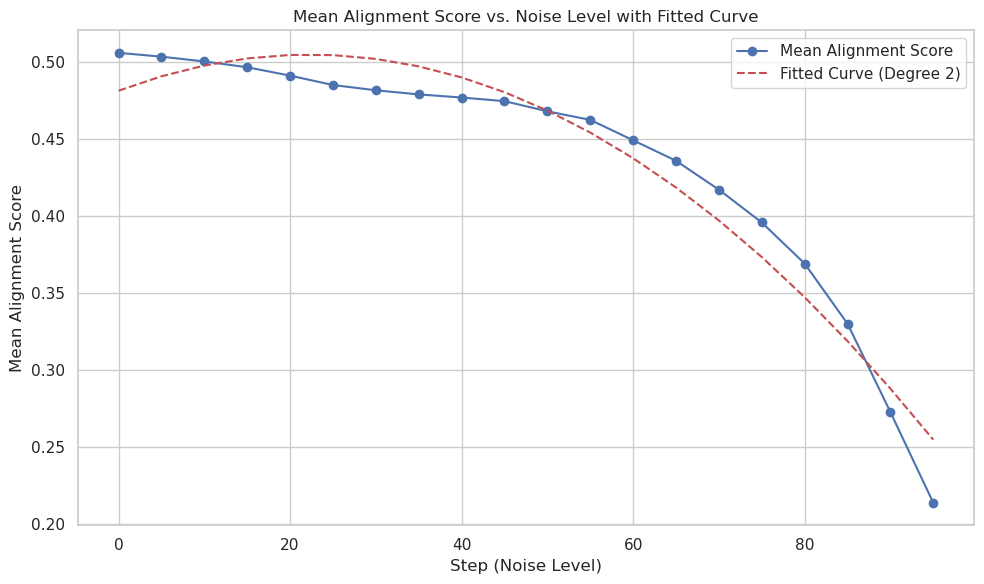

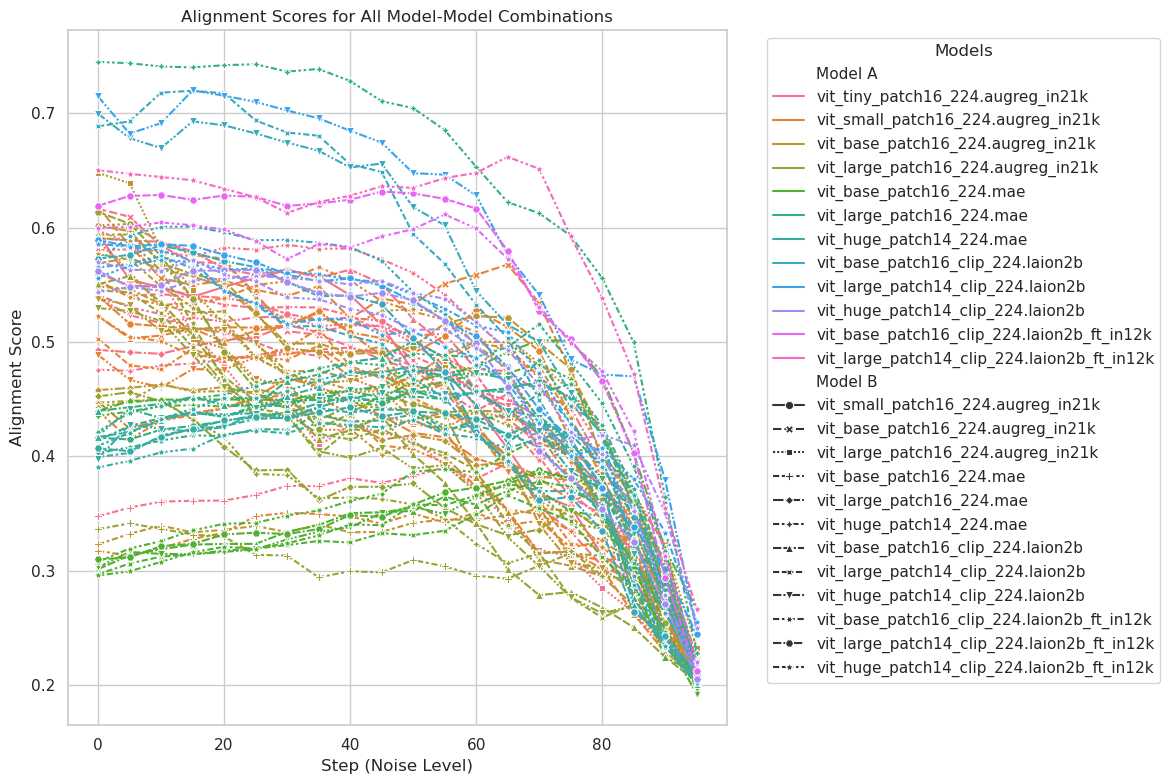

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load the data
df = pd.read_csv("alignment_scores.csv")

# Display the first few rows to understand the structure
print("Sample of the data:")
print(df.head())

# Calculate the mean score for each step
mean_scores = df.groupby('Step')['Score'].mean().reset_index()

# Display the calculated mean scores
print("\nMean alignment scores at each step:")
print(mean_scores)

# -------------------- Fitting a Curve --------------------

# Fit a polynomial regression (degree 2) to the mean scores
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(mean_scores[['Step']])
model = LinearRegression()
model.fit(X_poly, mean_scores['Score'])
mean_scores['Fitted'] = model.predict(X_poly)

# Plot the mean scores over different steps with the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(mean_scores['Step'], mean_scores['Score'], marker='o', linestyle='-', color='b', label='Mean Alignment Score')
plt.plot(mean_scores['Step'], mean_scores['Fitted'], linestyle='--', color='r', label='Fitted Curve (Degree 2)')
plt.xlabel('Step (Noise Level)')
plt.ylabel('Mean Alignment Score')
plt.title('Mean Alignment Score vs. Noise Level with Fitted Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------- Plotting All Model-Model Combinations --------------------

# Create a line plot for all model-model combinations over different steps
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Step', y='Score', hue='Model A', style='Model B', markers=True)
plt.xlabel('Step (Noise Level)')
plt.ylabel('Alignment Score')
plt.title('Alignment Scores for All Model-Model Combinations')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Models')
plt.tight_layout()
plt.show()


Scaling law: y = 0.4158 * x^-0.0124


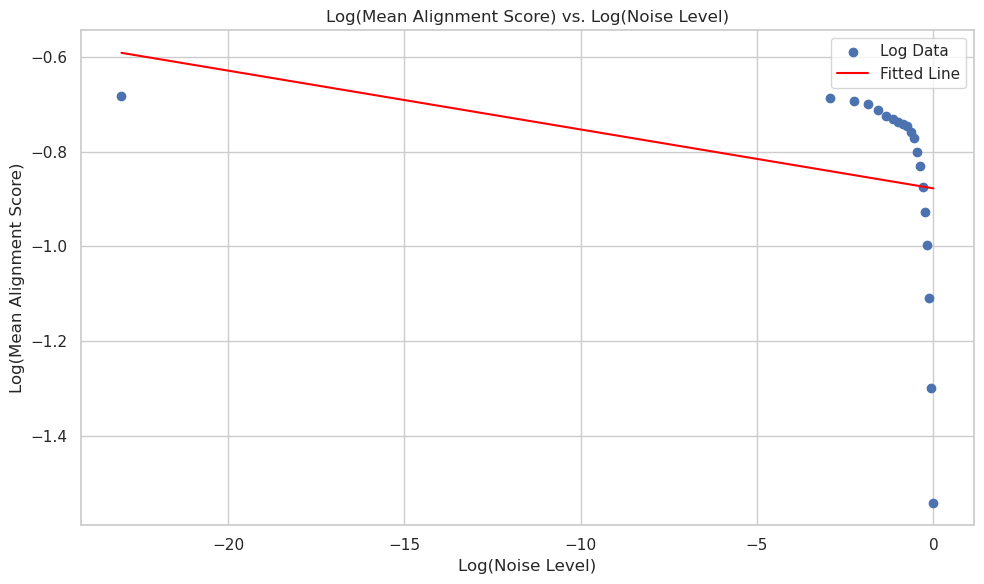

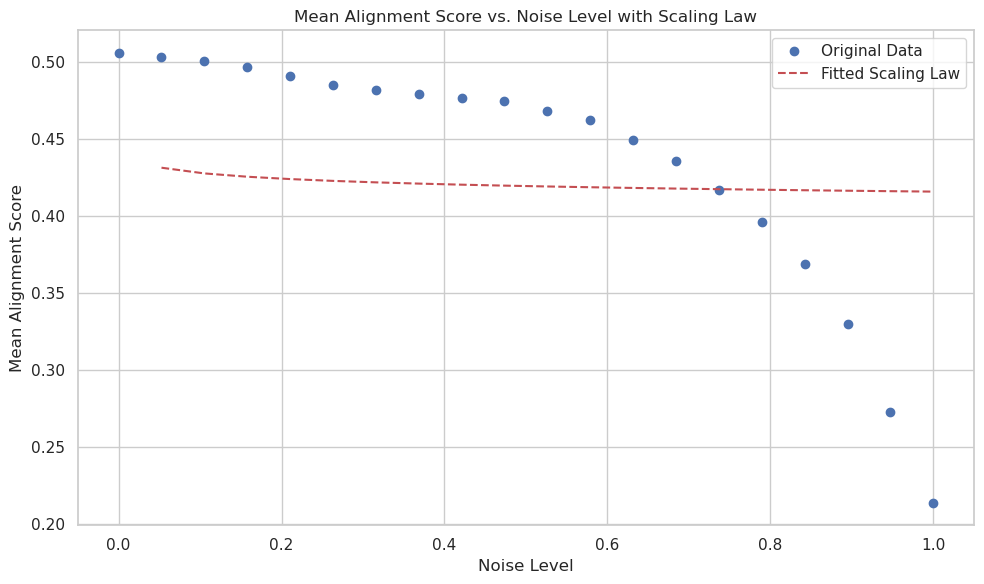

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the data
df = pd.read_csv("alignment_scores.csv")

# Calculate the mean alignment score for each step
mean_scores = df.groupby('Step')['Score'].mean().reset_index()

# Add a column for noise level (assuming Noise Level increases linearly with Step)
mean_scores['Noise Level'] = mean_scores['Step'] / mean_scores['Step'].max()

# Log-transform the mean alignment score and noise level
mean_scores['Log(Mean Alignment Score)'] = np.log(mean_scores['Score'])
mean_scores['Log(Noise Level)'] = np.log(mean_scores['Noise Level'] + 1e-10)  # Add small constant to avoid log(0)

# Perform linear regression on the log-transformed data
X = mean_scores[['Log(Noise Level)']].values.reshape(-1, 1)
y = mean_scores['Log(Mean Alignment Score)'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# Get the slope (scaling exponent) and intercept
slope = model.coef_[0][0]  # Scaling exponent b
intercept = model.intercept_[0]  # log(a)

# Convert the intercept back to a
a = np.exp(intercept)

# Print the scaling law
print(f"Scaling law: y = {a:.4f} * x^{slope:.4f}")

# Predict using the scaling law for plotting
mean_scores['Fitted'] = a * mean_scores['Noise Level'] ** slope

# -------------------- Plotting --------------------

# Plot the log-transformed data and the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(mean_scores['Log(Noise Level)'], mean_scores['Log(Mean Alignment Score)'], label="Log Data")
plt.plot(mean_scores['Log(Noise Level)'], model.predict(X), color='red', label="Fitted Line")
plt.title('Log(Mean Alignment Score) vs. Log(Noise Level)')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Mean Alignment Score)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the original data and fitted scaling law
plt.figure(figsize=(10, 6))
plt.plot(mean_scores['Noise Level'], mean_scores['Score'], 'o', label='Original Data')
plt.plot(mean_scores['Noise Level'], mean_scores['Fitted'], linestyle='--', color='r', label='Fitted Scaling Law')
plt.title('Mean Alignment Score vs. Noise Level with Scaling Law')
plt.xlabel('Noise Level')
plt.ylabel('Mean Alignment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
X = mean_scores[['Log(Noise Level)']].values.reshape(-1, 1)
y = mean_scores['Log(Mean Alignment Score)'].values.reshape(-1, 1)

In [64]:
mean_alignment_scores = mean_scores[["Step","Noise Level","Score"]]

In [65]:
mean_alignment_scores.to_csv("mean_alignment_scores.csv")

In [66]:
mean_alignment_scores

,Step,Noise Level,Score
0,0,0.000000,0.505711
1,5,0.052632,0.503208
2,10,0.105263,0.500117
3,15,0.157895,0.496359
4,20,0.210526,0.490928
5,25,0.263158,0.484844
6,30,0.315789,0.481440
7,35,0.368421,0.478751
8,40,0.421053,0.476744
9,45,0.473684,0.474392


Linear Fit MSE: 0.001533
Quadratic Fit MSE: 0.000311
Exponential fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Power Law Fit MSE: 0.018896

Best fit: Quadratic with MSE = 0.000311


/tmp/ipykernel_2874/823840917.py:26: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b)


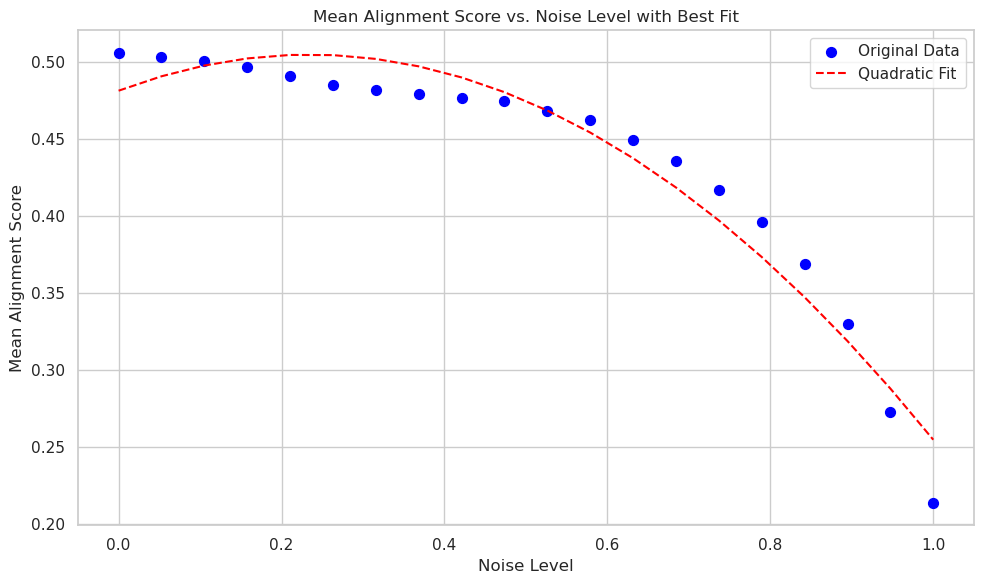

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# Assume 'mean_alignment_scores' DataFrame is already loaded with columns 'Noise Level' and 'Score'
# Example:
# mean_alignment_scores = pd.DataFrame({
#     'Step': range(0, 100, 5),
#     'Noise Level': [0.000000, 0.052632, 0.105263, ..., 1.000000],
#     'Score': [0.505711, 0.503208, 0.500117, ..., 0.214077]
# })

# Define curve functions
def linear(x, a, b):
    return a * x + b

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def power_law(x, a, b):
    return a * np.power(x, b)

# Extract Noise Level and Score
x_data = mean_alignment_scores['Noise Level'].values
y_data = mean_alignment_scores['Score'].values

# Fit curves and calculate Mean Squared Error (MSE)
curve_functions = {
    "Linear": linear,
    "Quadratic": quadratic,
    "Exponential": exponential,
    "Power Law": power_law
}

fit_results = {}
for name, func in curve_functions.items():
    try:
        popt, _ = curve_fit(func, x_data, y_data)
        y_pred = func(x_data, *popt)
        mse = mean_squared_error(y_data, y_pred)
        fit_results[name] = {'params': popt, 'mse': mse, 'y_pred': y_pred}
        print(f"{name} Fit MSE: {mse:.6f}")
    except Exception as e:
        print(f"{name} fit failed: {e}")

# Find the best fit based on the lowest MSE
best_fit_name = min(fit_results, key=lambda k: fit_results[k]['mse'])
best_fit_params = fit_results[best_fit_name]['params']
best_fit_y_pred = fit_results[best_fit_name]['y_pred']

print(f"\nBest fit: {best_fit_name} with MSE = {fit_results[best_fit_name]['mse']:.6f}")

# Plot the data and the best fit curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Original Data', s=50)
plt.plot(x_data, best_fit_y_pred, color='red', linestyle='--', label=f'{best_fit_name} Fit')
plt.title('Mean Alignment Score vs. Noise Level with Best Fit')
plt.xlabel('Noise Level')
plt.ylabel('Mean Alignment Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [73]:
# Total steps for noise addition
total_steps = 100

# Create a dictionary mapping each step to its corresponding noise level (alpha)
noise_levels_dict = {step: step / total_steps for step in range(total_steps + 1)}


In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the alignment scores data
alignment_df = pd.read_csv("alignment_scores.csv")

# Calculate the mean alignment score for each step
mean_alignment_scores = alignment_df.groupby('Step')['Score'].mean().reset_index()
mean_alignment_scores.columns = ['Step', 'Mean Alignment Score']


Combined Data Sample:
   Step  Mean Alignment Score  Noise Level  Signal Level
0     0              0.505711         0.00          1.00
1     5              0.503208         0.05          0.95
2    10              0.500117         0.10          0.90
3    15              0.496359         0.15          0.85
4    20              0.490928         0.20          0.80


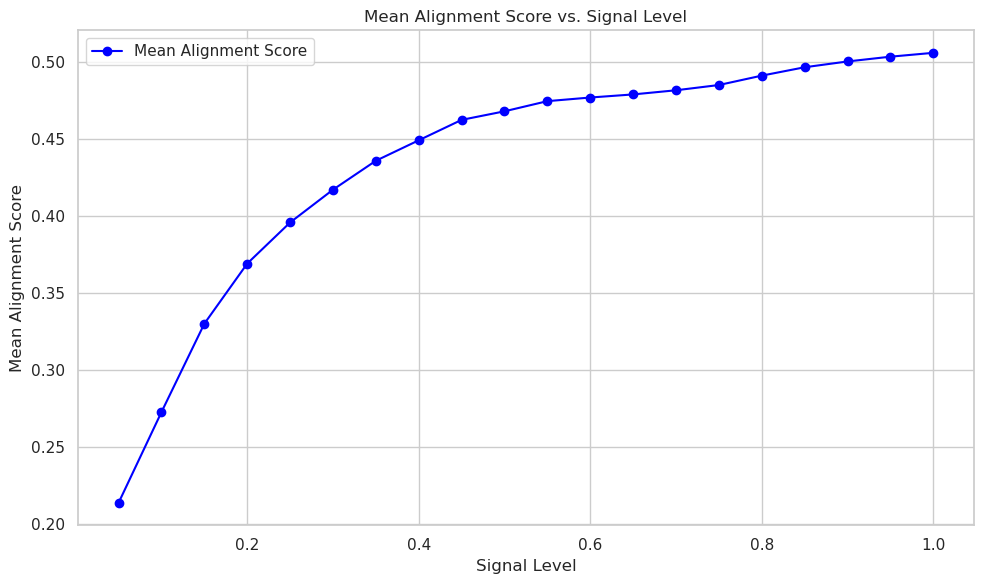

In [75]:
# Map the noise levels to the steps using the dictionary
mean_alignment_scores['Noise Level'] = mean_alignment_scores['Step'].map(noise_levels_dict)

# Calculate the signal level as (1 - Noise Level)
mean_alignment_scores['Signal Level'] = 1 - mean_alignment_scores['Noise Level']

# Display a few rows to verify the new DataFrame
print("\nCombined Data Sample:")
print(mean_alignment_scores.head())

# -------------------- Visualization --------------------

# Set up the plotting style
plt.figure(figsize=(10, 6))
plt.plot(mean_alignment_scores['Signal Level'], mean_alignment_scores['Mean Alignment Score'], marker='o', linestyle='-', color='blue', label='Mean Alignment Score')
plt.title('Mean Alignment Score vs. Signal Level')
plt.xlabel('Signal Level')
plt.ylabel('Mean Alignment Score')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


Combined Data Sample:
   Step  Mean Alignment Score  Noise Level  Signal Level
0     0              0.505711         0.00          1.00
1     5              0.503208         0.05          0.95
2    10              0.500117         0.10          0.90
3    15              0.496359         0.15          0.85
4    20              0.490928         0.20          0.80


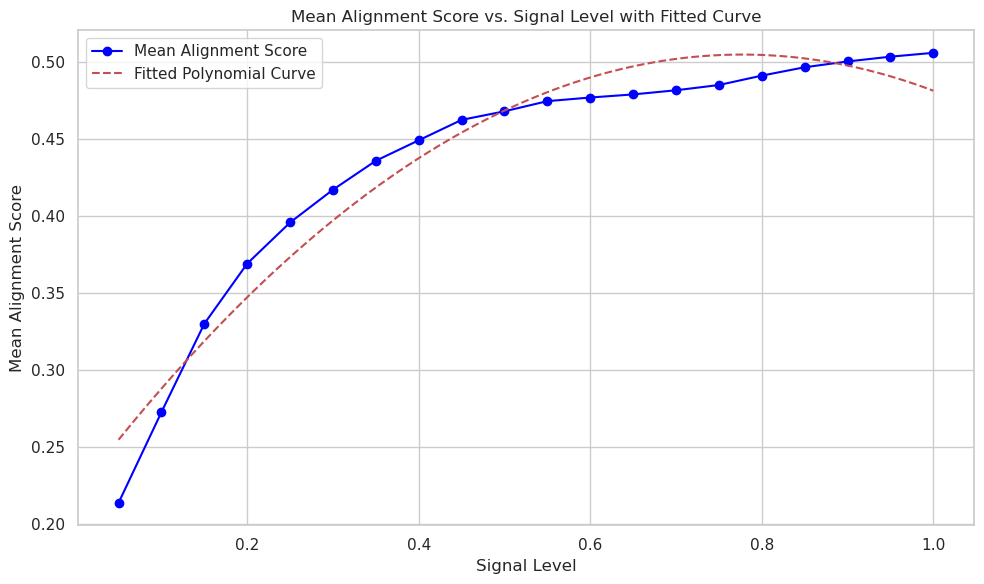

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Load the alignment scores data
alignment_df = pd.read_csv("alignment_scores.csv")

# Calculate the mean alignment score for each step
mean_alignment_scores = alignment_df.groupby('Step')['Score'].mean().reset_index()
mean_alignment_scores.columns = ['Step', 'Mean Alignment Score']

# Map the noise levels to the steps using the dictionary
mean_alignment_scores['Noise Level'] = mean_alignment_scores['Step'].map(noise_levels_dict)

# Calculate the signal level as (1 - Noise Level)
mean_alignment_scores['Signal Level'] = 1 - mean_alignment_scores['Noise Level']

# Display a few rows to verify the new DataFrame
print("\nCombined Data Sample:")
print(mean_alignment_scores.head())

# -------------------- Fit a Curve --------------------

# Define a polynomial function for fitting (you can adjust the degree)
def polynomial(x, a, b, c):
    return a * x**2 + b * x + c

# Get the signal levels and mean alignment scores as arrays for curve fitting
x_data = mean_alignment_scores['Signal Level']
y_data = mean_alignment_scores['Mean Alignment Score']

# Fit the curve
popt, _ = curve_fit(polynomial, x_data, y_data)

# Generate fitted values
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = polynomial(x_fit, *popt)

# -------------------- Visualization --------------------

# Set up the plotting style
plt.figure(figsize=(10, 6))
plt.plot(mean_alignment_scores['Signal Level'], mean_alignment_scores['Mean Alignment Score'], marker='o', linestyle='-', color='blue', label='Mean Alignment Score')
plt.plot(x_fit, y_fit, 'r--', label='Fitted Polynomial Curve')
plt.title('Mean Alignment Score vs. Signal Level with Fitted Curve')
plt.xlabel('Signal Level')
plt.ylabel('Mean Alignment Score')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


Fitted Polynomial Formula: A(S) = -0.47200 * S^2 + 0.73375 * S + 0.21943
Where:
  a = -0.47200
  b = 0.73375
  c = 0.21943


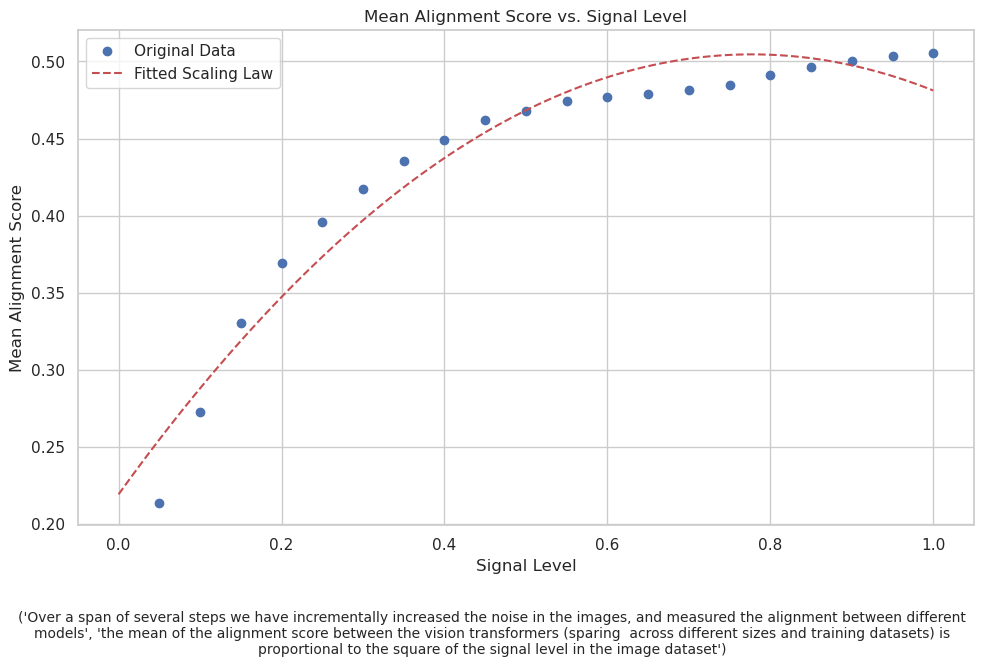

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Assuming mean_alignment_scores is already defined with 'Signal Level' and 'Mean Alignment Score'
# mean_alignment_scores = pd.DataFrame(...)  # your DataFrame here

# Define a quadratic function to fit
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the curve using scipy's curve_fit
popt, pcov = curve_fit(
    quadratic_func, 
    mean_alignment_scores['Signal Level'], 
    mean_alignment_scores['Mean Alignment Score']
)

# Extract the coefficients
a, b, c = popt

# Print the coefficients and the resulting formula
print(f"Fitted Polynomial Formula: A(S) = {a:.5f} * S^2 + {b:.5f} * S + {c:.5f}")
print(f"Where:")
print(f"  a = {a:.5f}")
print(f"  b = {b:.5f}")
print(f"  c = {c:.5f}")

# Plot the original data and the fitted curve for visualization
signal_values = np.linspace(0, 1, 100)  # Generate 100 points between 0 and 1 for a smooth curve
fitted_values = quadratic_func(signal_values, *popt)

plt.figure(figsize=(10, 6))
plt.plot(mean_alignment_scores['Signal Level'], mean_alignment_scores['Mean Alignment Score'], 'o', label='Original Data')
plt.plot(signal_values, fitted_values, 'r--', label='Fitted Scaling Law')
plt.xlabel('Signal Level')
plt.ylabel('Mean Alignment Score')
plt.title('Mean Alignment Score vs. Signal Level')
description_text = (
    "Over a span of several steps we have incrementally increased the noise in the images, and measured the alignment between different models",
    "the mean of the alignment score between the vision transformers (sparing  across different sizes and training datasets) is proportional to the square of the signal level in the image dataset"
)

# Adjust the position of the text (0.5 is centered horizontally, -0.1 places it below the plot)
plt.figtext(0.5, -0.1, description_text, wrap=True, horizontalalignment='center', fontsize=10)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
